# Prediction Models (classification / regression)

In [59]:
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, MultiLabelBinarizer
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, plot_tree

import numpy as np
import pandas as pd

## Preprocessing

In [39]:
df = pd.read_csv("./../../data/goodreads_data.csv", converters={"genres": lambda x: x[1:-1].split(",")})
df["publication_date"] = pd.to_datetime(df["published"].apply(lambda x: " ".join(str(x).split()[:3])), errors="coerce")
df["publication_year"] = df["publication_date"].dt.year.astype("float")
df["n_pages"] = df["pages_format"].apply(lambda x: int(x.split()[0]) if x.split()[0].isdigit() else np.nan).astype("float")
df["format"] = df["pages_format"].apply(lambda x: x.replace("Kindle Edition", "Kindle").split()[-1].lower() if x.replace("Kindle Edition", "Kindle").split()[-1].lower() in ["hardcover", "paperback", "ebook", "audiobook", "audio", "cd", "kindle"] else "other").astype("category")

dic_rating = {1: "one_star", 2: "two_stars", 3: "three_stars", 4: "four_stars", 5: "five_stars"}
for key, value in dic_rating.items():
    df[value] = df["ratings"].apply(lambda x: float(x[1:-1].split(",")[key-1])) / df["n_ratings"]
df["average_rating"] = df["ratings"].apply(lambda x: sum([(i+1) * float(x[1:-1].split(",")[i]) for i in range(5)])) / df["n_ratings"]

df.head(5)

,title,author,price,description,author_description,genres,n_ratings,n_reviews,ratings,pages_format,...,setting,publication_date,publication_year,n_pages,one_star,two_stars,three_stars,four_stars,five_stars,average_rating
0,The Weed That Strings the Hangman's Bag,Alan Bradley,4.99,From Dagger Award-winning and internationally ...,Librarian Note: There is more than one author ...,"['Mystery', 'Fiction', 'Historical Fiction',...",55692.0,5756.0,"[395.0, 1540.0, 12237.0, 25714.0, 15806.0]","364 pages, Hardcover",...,NaN,2010-03-09,2010.0,364.0,0.007093,0.027652,0.219726,0.461718,0.283811,3.987503
1,A Good Man in Africa,William Boyd,11.99,"In the small African republic of Kinjanja, Bri...","Note: William^^BoydOf Scottish descent, Boyd w...","['Fiction', 'Africa', 'Humor', 'Novels', '...",5018.0,298.0,"[90.0, 257.0, 1222.0, 2184.0, 1265.0]","352 pages, Paperback",...,['Kinjanja'],2003-01-14,2003.0,352.0,0.017935,0.051216,0.243523,0.435233,0.252092,3.852332
2,It Had to Be You,Janice Thompson,0.00,Bella couldn't be happier that her long-feudin...,"Welcome to the wacky, wonderful world of inspi...","['Christian Fiction', 'Romance', 'Christian'...",2152.0,132.0,"[14.0, 86.0, 421.0, 735.0, 896.0]","336 pages, Paperback",...,"['Galveston, Texas']",2010-05-01,2010.0,336.0,0.006506,0.039963,0.195632,0.341543,0.416357,4.121283
3,Missing,Kelley Armstrong,6.99,Everyone knows they left. No one knows they're...,Kelley Armstrong has been telling stories sinc...,"['Young Adult', 'Mystery', 'Thriller', 'Fic...",3393.0,491.0,"[54.0, 185.0, 799.0, 1308.0, 1047.0]","515 pages, ebook",...,NaN,2017-04-18,2017.0,515.0,0.015915,0.054524,0.235485,0.385500,0.308576,3.916298
4,Dawn of Rebellion,Michelle Lynn,0.00,"My name is Dawn Nolan, and I've grown up on th...",Michelle moved around the Midwest most of her ...,"['Young Adult', 'Dystopia', 'Romance', 'Sci...",142.0,76.0,"[1.0, 6.0, 23.0, 41.0, 71.0]","321 pages, Paperback",...,NaN,2013-10-17,2013.0,321.0,0.007042,0.042254,0.161972,0.288732,0.500000,4.232394


In [40]:
print("Number of books (with duplicates): ", len(df))
df.drop_duplicates(subset=["title", "author"], keep='first', inplace=True, ignore_index=True)
print("Number of books (without duplicates): ", len(df))

Number of books (with duplicates):  24630
Number of books (without duplicates):  19666


## Formats Classification

In [41]:
features = ["price", "n_ratings", "n_reviews", "publication_year", "n_pages", "average_rating"]
print("Number of features: ", len(features))

Number of features:  6


In [42]:
df_format = df[features + ["format"]].dropna()

X_format = df_format[features].values
X_format = MinMaxScaler().fit_transform(X_format)

lb = LabelEncoder()
y_format = lb.fit_transform(df_format["format"].values)

print("Number of classes: ", len(lb.classes_))

Number of classes:  8


In [43]:
scores = {}

### K Nearest Neighbors

In [44]:
params = {
    "n_neighbors": range(3, 21, 2),
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

gridsearch = GridSearchCV(KNeighborsClassifier(), params, cv=5)
gridsearch = gridsearch.fit(X_format, y_format)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["KNN"] = cross_val_score(gridsearch.best_estimator_, X_format, y_format, cv=10)

Best parameters:  {'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
Best score:  0.6054517446729996


C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


### Logistic Regression

In [45]:
params = {
    "max_iter": [500, 1000, 2000],
    "C": [0.1, 1, 10, 100],
    "class_weight": ["balanced", None],
    "solver": ["liblinear", "lbfgs"]
}

gridsearch = GridSearchCV(LogisticRegression(), params, cv=5)
gridsearch = gridsearch.fit(X_format, y_format)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["LogisticRegression"] = cross_val_score(gridsearch.best_estimator_, X_format, y_format, cv=10)

Best parameters:  {'C': 100, 'class_weight': None, 'max_iter': 500, 'solver': 'liblinear'}
Best score:  0.5767803948477317


C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


### Decision Tree

In [46]:
params = {
    "criterion": ["gini", "entropy"],
    "max_depth": range(3, 11),
}

gridsearch = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
gridsearch = gridsearch.fit(X_format, y_format)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["DecisionTree"] = cross_val_score(gridsearch.best_estimator_, X_format, y_format, cv=10)

Best parameters:  {'criterion': 'gini', 'max_depth': 7}
Best score:  0.6172766311699834


C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


[Text(0.4721563981042654, 0.9375, 'publication_year <= 0.911\ngini = 0.636\nsamples = 19113\nvalue = [8.0, 36.0, 55.0, 945.0, 5177.0, 2739.0, 265.0, 9888.0]\nclass = paperback'),
 Text(0.22985781990521326, 0.8125, 'publication_year <= 0.9\ngini = 0.357\nsamples = 7421\nvalue = [0, 5, 11, 28, 1487, 39, 91, 5760]\nclass = paperback'),
 Text(0.11670616113744076, 0.6875, 'publication_year <= 0.716\ngini = 0.3\nsamples = 5761\nvalue = [0, 3, 2, 18, 899, 26, 80, 4733]\nclass = paperback'),
 Text(0.0485781990521327, 0.5625, 'average_rating <= 0.528\ngini = 0.57\nsamples = 186\nvalue = [0, 0, 0, 3, 86, 2, 9, 86]\nclass = hardcover'),
 Text(0.023696682464454975, 0.4375, 'n_pages <= 0.005\ngini = 0.497\nsamples = 29\nvalue = [0, 0, 0, 2, 3, 1, 3, 20]\nclass = paperback'),
 Text(0.009478672985781991, 0.3125, 'price <= 0.005\ngini = 0.625\nsamples = 4\nvalue = [0, 0, 0, 1, 0, 1, 2, 0]\nclass = other'),
 Text(0.004739336492890996, 0.1875, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 0, 0, 0, 0, 2, 0]\n

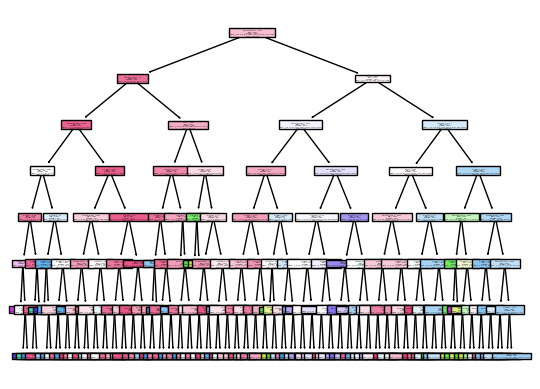

In [47]:
plot_tree(gridsearch.best_estimator_, feature_names=features, class_names=lb.classes_, filled=True)

### Random Forest

In [48]:
params = {
    "n_estimators": [100, 250, 500],
    "max_depth": [50, 100, None]
}

gridsearch = GridSearchCV(RandomForestClassifier(), params, cv=5)
gridsearch = gridsearch.fit(X_format, y_format)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["RandomForest"] = cross_val_score(gridsearch.best_estimator_, X_format, y_format, cv=10)

Best parameters:  {'max_depth': 100, 'n_estimators': 100}
Best score:  0.6299379817521891


C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


### Support Vector Classifier

In [49]:
params = {
    "C": [1, 10, 100],
    "kernel": ["rbf", "sigmoid"],
    "degree": range(2, 5),
}

gridsearch = GridSearchCV(SVC(), params, cv=5)
gridsearch = gridsearch.fit(X_format, y_format)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["SVC"] = cross_val_score(gridsearch.best_estimator_, X_format, y_format, cv=10)

Best parameters:  {'C': 100, 'degree': 2, 'kernel': 'rbf'}
Best score:  0.5863023565127373


C:\Users\Ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


### Models Comparison

In [50]:
algorithms = list(scores.keys())

for algo1, algo2 in combinations(algorithms, 2):
    print(f"Comparing {algo1} and {algo2}")
    t, p = ttest_ind(scores[algo1], scores[algo2])
    print(f"\tAccuracy: p = {p:.5f}")

Comparing KNN and LogisticRegression
	Accuracy: p = 0.00000
Comparing KNN and DecisionTree
	Accuracy: p = 0.00302
Comparing KNN and RandomForest
	Accuracy: p = 0.00001
Comparing KNN and SVC
	Accuracy: p = 0.00003
Comparing LogisticRegression and DecisionTree
	Accuracy: p = 0.00000
Comparing LogisticRegression and RandomForest
	Accuracy: p = 0.00000
Comparing LogisticRegression and SVC
	Accuracy: p = 0.00323
Comparing DecisionTree and RandomForest
	Accuracy: p = 0.01685
Comparing DecisionTree and SVC
	Accuracy: p = 0.00000
Comparing RandomForest and SVC
	Accuracy: p = 0.00000


In [51]:
for algo, score in scores.items():
    print(f"{algo}: {score.mean():.5f} +/- {score.std():.5f}")

KNN: 0.60488 +/- 0.00854
LogisticRegression: 0.57793 +/- 0.00483
DecisionTree: 0.61806 +/- 0.00778
RandomForest: 0.62779 +/- 0.00790
SVC: 0.58609 +/- 0.00536


## Genres Classification

In [79]:
features = ["price", "n_ratings", "n_reviews", "publication_year", "n_pages", "average_rating"]
print("Number of features: ", len(features))

Number of features:  6


In [80]:
df_tmp = df[features + ["genres"]].explode("genres")
df_tmp["genres"] = df_tmp["genres"].apply(lambda x: x.strip()[1:-1]) 
df_tmp["genres"].astype("category")
df_tmp = df_tmp[df_tmp["genres"] != "...more"]

genres_counts = df_tmp["genres"].value_counts()
most_common_genres_counts = genres_counts.head(10)
most_common_genres = most_common_genres_counts.index.tolist()

In [81]:
df_genres = df[features + ["genres"]].dropna()
df_genres["genres"] = df_genres["genres"].apply(lambda x: list(set([genre.strip()[1:-1] if genre.strip()[1:-1] in most_common_genres else "Other" for genre in x])))

X_genres = df_genres[features].values
X_genres = MinMaxScaler().fit_transform(X_genres)

mlb = MultiLabelBinarizer()
y_genres = mlb.fit_transform(df_genres["genres"].values)

print("Number of classes: ", len(mlb.classes_))

Number of classes:  11


In [82]:
scores = {}

### K Nearest Neighbors

In [88]:
params = {
    "n_neighbors": range(15, 21, 2),
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

gridsearch = GridSearchCV(KNeighborsClassifier(), params, cv=5)
gridsearch = gridsearch.fit(X_genres, y_genres)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["KNN"] = cross_val_score(gridsearch.best_estimator_, X_genres, y_genres, cv=10)

Best parameters:  {'n_neighbors': 19, 'p': 1, 'weights': 'distance'}
Best score:  0.13263235151804337


### Decision Tree

In [83]:
params = {
    "criterion": ["gini", "entropy"],
    "max_depth": range(3, 11),
}

gridsearch = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
gridsearch = gridsearch.fit(X_genres, y_genres)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["DecisionTree"] = cross_val_score(gridsearch.best_estimator_, X_genres, y_genres, cv=10)

Best parameters:  {'criterion': 'gini', 'max_depth': 10}
Best score:  0.1583217773718876


[Text(0.534421875, 0.9545454545454546, 'price <= 0.055\ngini = 0.299\nsamples = 19113\nvalue = [[15435.0, 3678.0]\n[14337.0, 4776.0]\n[9300.0, 9813.0]\n[16787.0, 2326.0]\n[16415.0, 2698.0]\n[16598.0, 2515.0]\n[16178.0, 2935.0]\n[14120.0, 4993.0]\n[278.0, 18835.0]\n[13250.0, 5863.0]\n[15389.0, 3724.0]]'),
 Text(0.2664739583333333, 0.8636363636363636, 'publication_year <= 0.911\ngini = 0.295\nsamples = 14171\nvalue = [[11015.0, 3156.0]\n[10050.0, 4121.0]\n[6404.0, 7767.0]\n[12629.0, 1542.0]\n[12238.0, 1933.0]\n[13049.0, 1122.0]\n[11840.0, 2331.0]\n[11835.0, 2336.0]\n[255.0, 13916.0]\n[8883.0, 5288.0]\n[10839.0, 3332.0]]'),
 Text(0.12965625, 0.7727272727272727, 'n_ratings <= 0.0\ngini = 0.272\nsamples = 5046\nvalue = [[4581.0, 465.0]\n[3781.0, 1265.0]\n[1620.0, 3426.0]\n[4357.0, 689.0]\n[4154.0, 892.0]\n[4358.0, 688.0]\n[4154.0, 892.0]\n[3772.0, 1274.0]\n[32.0, 5014.0]\n[4209.0, 837.0]\n[4165.0, 881.0]]'),
 Text(0.06104166666666667, 0.6818181818181818, 'n_pages <= 0.013\ngini = 0.242\nsam

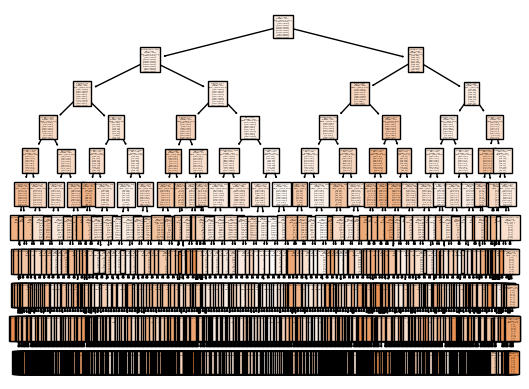

In [84]:
plot_tree(gridsearch.best_estimator_, feature_names=features, class_names=lb.classes_, filled=True)

### Random Forest

In [85]:
params = {
    "n_estimators": [100, 250, 500],
    "max_depth": [50, 100, None]
}

gridsearch = GridSearchCV(RandomForestClassifier(), params, cv=5)
gridsearch = gridsearch.fit(X_genres, y_genres)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["RandomForest"] = cross_val_score(gridsearch.best_estimator_, X_genres, y_genres, cv=10)

Best parameters:  {'max_depth': None, 'n_estimators': 250}
Best score:  0.17841257430958862


### Models Comparison

In [89]:
algorithms = list(scores.keys())

for algo1, algo2 in combinations(algorithms, 2):
    print(f"Comparing {algo1} and {algo2}")
    t, p = ttest_ind(scores[algo1], scores[algo2])
    print(f"\tAccuracy: p = {p:.5f}")

Comparing DecisionTree and RandomForest
	Accuracy: p = 0.00001
Comparing DecisionTree and KNN
	Accuracy: p = 0.00000
Comparing RandomForest and KNN
	Accuracy: p = 0.00000


In [90]:
for algo, score in scores.items():
    print(f"{algo}: {score.mean():.3f} +/- {score.std():.3f}")

DecisionTree: 0.161 +/- 0.007
RandomForest: 0.179 +/- 0.005
KNN: 0.132 +/- 0.005


## Ratings Prediction

In [4]:
features = ["price", "publication_year", "n_pages"]
print("Number of features: ", len(features))

Number of features:  3


In [5]:
df_ratings = df[features + ["average_rating"]].dropna()
df_ratings = (df_ratings - df_ratings.mean()) / df_ratings.std()

In [6]:
X_ratings = df_ratings[features].values
y_ratings = df_ratings["average_rating"].values

In [7]:
scores = {}

### Linear Regression

In [8]:
scores["LinearRegression"] = cross_val_score(LinearRegression(), X_ratings, y_ratings, cv=10)

### Support Vector Regression

In [17]:
params = {
    "C": [0.1, 1, 10],
    "kernel": ["rbf", "sigmoid"],
    "degree": range(2, 5),
}

gridsearch = GridSearchCV(SVR(), params, cv=5)
gridsearch = gridsearch.fit(X_ratings, y_ratings)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["SVR"] = cross_val_score(gridsearch.best_estimator_, X_ratings, y_ratings, cv=10)

Best parameters:  {'C': 1, 'degree': 5, 'kernel': 'rbf'}
Best score:  0.0781347292517032


### Models Comparison

In [18]:
algorithms = list(scores.keys())

for algo1, algo2 in combinations(algorithms, 2):
    print(f"Comparing {algo1} and {algo2}")
    t, p = ttest_ind(scores[algo1], scores[algo2])
    print(f"\tp = {p:.5f}")

Comparing LinearRegression and SVR
	p = 0.00000


In [19]:
print(scores)

{'LinearRegression': array([-0.00875349,  0.0336435 ,  0.02257031,  0.03149923,  0.02917137,
        0.01850274,  0.02369697, -0.03198963,  0.02015626,  0.02328244]), 'SVR': array([0.07116176, 0.09603926, 0.06699991, 0.09215496, 0.08493985,
       0.07236532, 0.08556956, 0.06266163, 0.08193054, 0.07263491])}


## Number of Ratings

In [22]:
features = ["price", "publication_year", "n_pages"]
print("Number of features: ", len(features))

Number of features:  3


In [23]:
df_n_ratings = df[features + ["n_ratings"]].dropna()
df_n_ratings = (df_n_ratings - df_n_ratings.mean()) / df_n_ratings.std()

In [26]:
X_n_ratings = df_n_ratings[features].values
y_n_ratings = df_n_ratings["n_ratings"].values

In [27]:
scores = {}

### Linear Regression

In [28]:
scores["LinearRegression"] = cross_val_score(LinearRegression(), X_n_ratings, y_n_ratings, cv=10)

### Support Vector Regression

In [30]:
params = {
    "C": [0.1, 1, 10],
    "kernel": ["rbf", "sigmoid"],
    "degree": range(2, 5),
}

gridsearch = GridSearchCV(SVR(), params, cv=5)
gridsearch = gridsearch.fit(X_n_ratings, y_n_ratings)

print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

scores["SVR"] = cross_val_score(gridsearch.best_estimator_, X_n_ratings, y_n_ratings, cv=10)

Best parameters:  {'C': 10, 'degree': 2, 'kernel': 'rbf'}
Best score:  -0.004375721747325967


### Models Comparison

In [31]:
algorithms = list(scores.keys())

for algo1, algo2 in combinations(algorithms, 2):
    print(f"Comparing {algo1} and {algo2}")
    t, p = ttest_ind(scores[algo1], scores[algo2])
    print(f"\tp = {p:.5f}")

Comparing LinearRegression and SVR
	p = 0.02494


In [32]:
print(scores)

{'LinearRegression': array([ 0.00085032, -0.00022707, -0.00053508,  0.00019956,  0.00208744,
        0.00154418,  0.00385419, -0.0063525 ,  0.00139332, -0.00319414]), 'SVR': array([-0.00886858, -0.00599721, -0.00944616, -0.0084715 , -0.00584427,
        0.0088174 , -0.00465124, -0.00433837, -0.00357255, -0.00391408])}


In [37]:
print(np.std(scores["LinearRegression"]))

0.0027419162340064727
